In [75]:
import numpy as np
np.random.seed(seed=42)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import copy

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

Text(0.5, 1.0, 'Зависисмость дисперсии объекта от его скора')

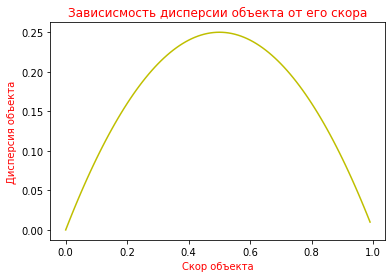

In [76]:
t = np.arange(0.0, 1.0, 0.01)
s = t - t**2
plt.plot(t, s, 'y')
plt.xlabel('Скор объекта', color='r')
plt.ylabel('Дисперсия объекта', color='r')
plt.title('Зависисмость дисперсии объекта от его скора', color='r')

In [77]:
def preprocess(arr):
    ones = np.array([[1]*arr.shape[0]]).T
    arr_b = np.concatenate((ones, arr), axis=1)
    return arr_b

In [78]:
def sigmoid(z):
    # Activation function used to map any real value between 0 and 1
    sig = 1 / (1 + np.exp(-z))     # Define sigmoid function
    sig = np.minimum(sig, 0.99999999999999999999999999)  # Set upper bound
    sig = np.maximum(sig, 0.00000000000000000000000001)  # Set lower bound
    return sig 

In [79]:
def cross_entropy(T, Y):
    # Computes the cost function for all the training samples
    E = 0
    for i in range(T.shape[0]):
        if T[i] == 1:
            E -= np.log(Y[i])
        else:
            E -= np.log(1 - Y[i])
    return E

In [80]:
def fit(X, T, iterations):
    
    X = copy.deepcopy(X)
    T = copy.deepcopy(T)
    
    N = X.shape[0]
    D = X.shape[1]
    
    Xb = preprocess(X)
    w = np.random.randn(D + 1)

    list_w = []
    list_var_w = []
    list_var_obj = []
    costs = []

    for i in range(iterations):

        Y_hat = sigmoid(Xb.dot(w))
        Y = Y_hat
        Y[Y==1.0] = 0.999999999999
        Y[Y==0.0] = 0.000000000001

        costs += [cross_entropy(T, Y)]

        b = Y*(1-Y)
        B = np.diag(b)

        inverse_of_A = np.dot(w.reshape(D+1,1), w.reshape(1,D+1))/D
        cov_w_matrix = np.linalg.pinv(inverse_of_A)
        var_w = cov_w_matrix.diagonal()

        Xt = np.transpose(Xb)
        XtB = Xt.dot(B)
        XtBX = XtB.dot(Xb)
        print(i)
        print(w)
        print(Y)
        #inverse_of_H = np.linalg.pinv(XtBX + var_w*1e-19)
        inverse_of_H = np.linalg.pinv(XtBX + var_w)

        derivative_of_logloss = np.dot(Xb.T, (Y-T))

        w = w - inverse_of_H.dot(derivative_of_logloss + var_w*w)



       # w = w - learning_rate *(np.dot(Xb.T, (Y-T)) + var_w*w*1e-19)

       # inverse_of_A = np.dot(w.reshape(D+1,1), w.reshape(1,D+1))/D
       # var_w = np.linalg.pinv(inverse_of_A).diagonal()
        list_w.append(w)
        list_var_w.append(var_w)
        list_var_obj.append(Y*(1-Y))
        
        
        #print(w)
        #print(i)

    return w, list_w, list_var_w, list_var_obj, costs

In [81]:
def fit_with_obj_feat_selection(X, T, iterations, obj_threshold, feat_threshold):
    
    X = copy.deepcopy(X)
    T = copy.deepcopy(T)
        
    N = X.shape[0]
    D = X.shape[1]
    
    Xb = preprocess(X)
    cols = [str(i) for i in range(Xb.shape[1])]
    w = np.random.randn(D + 1)

    list_w = []
    list_var_w = []
    list_var_obj = []
    costs = []

    for i in range(iterations):

        Y_hat = sigmoid(Xb.dot(w))
        Y = Y_hat
        Y[Y==1.0] = 0.999999999999
        Y[Y==0.0] = 0.000000000001
        b_temp = Y*(1-Y)

#         print('Итерация', i)
#         print(Y)
#         mask = b_temp<0.2499
        mask = b_temp<obj_threshold
        Xb = Xb[mask]
        Y = Y[mask]
        T = T[mask]
#         print('Итерация', i)
#         print(Y)

        costs += [cross_entropy(T, Y)]

        b = Y*(1-Y)
        B = np.diag(b)
        
        inverse_of_A = np.dot(w.reshape(Xb.shape[1],1), w.reshape(1,Xb.shape[1]))/Xb.shape[1]
        cov_w_matrix = np.linalg.pinv(inverse_of_A)
        var_w = cov_w_matrix.diagonal()
        
        print(cols)
#         mask2 = var_w<1.0
        mask2 = var_w<feat_threshold
        cols = [col for col, mask in zip(cols, mask2) if mask]
        w = w[mask2]
        #w[~mask2]=np.nan
        Xb = Xb[:, mask2]
        print(i)
        print(mask2)
        print(cols)
        print(w)
        print(Xb.shape)

        inverse_of_A = np.dot(w.reshape(Xb.shape[1],1), w.reshape(1,Xb.shape[1]))/Xb.shape[1]
        cov_w_matrix = np.linalg.pinv(inverse_of_A)
        var_w = cov_w_matrix.diagonal()

        Xt = np.transpose(Xb)
        XtB = Xt.dot(B)
        XtBX = XtB.dot(Xb)
        print(i)
        print(w)
        print(Y)
        #inverse_of_H = np.linalg.pinv(XtBX + var_w*1e-19)
        inverse_of_H = np.linalg.pinv(XtBX + var_w)

        derivative_of_logloss = np.dot(Xb.T, (Y-T))

        w = w - inverse_of_H.dot(derivative_of_logloss + var_w*w)

        list_w.append(w)
        list_var_w.append(var_w)
        list_var_obj.append(Y*(1-Y))
        
        
        #print(w)
        #print(i)

    return w, list_w, list_var_w, list_var_obj, costs, cols

In [82]:
def predict_estimates(X_test, w):
    Xb_test = preprocess(X_test)
    z_test = Xb_test.dot(w)
    probability_estimates = sigmoid(z_test)
    return probability_estimates

In [83]:
def accuracy(x, actual_classes, probab_threshold=0.5):
    predicted_classes = (x >= 
                         probab_threshold).astype(int)
    predicted_classes = predicted_classes.flatten()
    accuracy = np.mean(predicted_classes == actual_classes)
    return accuracy * 100

In [84]:
def plot_weights(weights):
    plt.scatter(np.arange(len(weights)), weights, label='w map')
    plt.legend()

In [85]:
from sklearn.datasets import make_classification

In [86]:
ds = make_classification(n_samples=1550, n_features=2, n_redundant=0, 
                         flip_y=0.33, random_state=42)

In [87]:
X, T = ds

In [88]:
X, X_test, T, t_test = train_test_split(X, T, test_size=0.33, random_state=42)

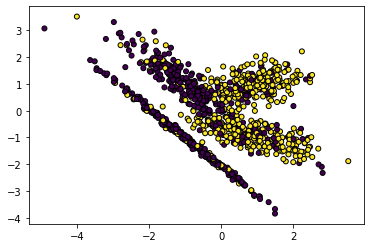

In [89]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=T, s=25, edgecolor='k')

In [90]:
w1, list_w1, list_var_w1, list_var_obj1, costs1 = fit(X=X, T=T, iterations=15)

0
[ 0.49671415 -0.1382643   0.64768854]
[0.71748132 0.70475592 0.46824716 ... 0.15908137 0.33900952 0.72382519]
1
[-0.25727375  1.21432973  0.03178364]
[0.77084668 0.85521504 0.61601837 ... 0.67878177 0.72189873 0.22295213]
2
[0.06178258 0.96370843 0.40584576]
[0.82933316 0.88380577 0.58055529 ... 0.41660678 0.60422265 0.37330478]
3
[0.01196523 1.05718469 0.36756721]
[0.83293753 0.89069507 0.59030844 ... 0.4548425  0.62964485 0.33932153]
4
[0.0097344  1.06525031 0.36697886]
[0.83388102 0.89171628 0.59110178 ... 0.45656895 0.6312929  0.33725108]
5
[0.00979563 1.06539953 0.3670605 ]
[0.83392449 0.89175328 0.59112266 ... 0.45655416 0.63131327 0.33724698]
6
[0.00979708 1.06540246 0.36706225]
[0.8339254  0.89175405 0.5911231  ... 0.45655382 0.63131368 0.33724697]
7
[0.00979711 1.06540252 0.36706229]
[0.83392542 0.89175406 0.59112311 ... 0.45655382 0.63131369 0.33724697]
8
[0.00979711 1.06540252 0.36706229]
[0.83392542 0.89175406 0.59112311 ... 0.45655382 0.63131369 0.33724697]
9
[0.00979711

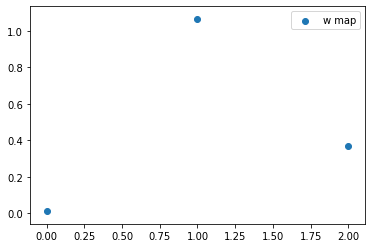

In [91]:
plot_weights(w1)

In [92]:
# for i in range(len(list_var_obj1[0])):
#     a = []
#     for j in range(len(list_var_obj1)):
#         a.append(list_var_obj1[j][i])
#     plt.plot(a)
#     #plt.show()

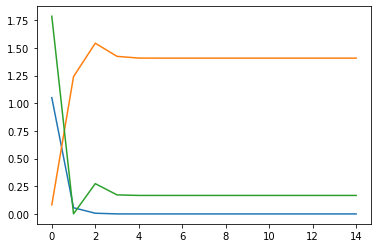

In [93]:
for i in range(len(list_var_w1[0])):
    a = []
    for j in range(len(list_var_w1)):
        a.append(list_var_w1[j][i])
    plt.plot(a)
    #plt.show()

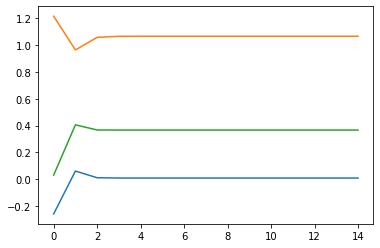

In [94]:
for i in range(len(list_w1[0])):
    a = []
    for j in range(len(list_w1)):
        a.append(list_w1[j][i])
    plt.plot(a)
    #plt.show()

In [95]:
# for i in range(len(list_var_obj1[0])):
#     a = []
#     for j in range(len(list_var_obj1)):
#         a.append(list_var_obj1[j][i])
#     plt.plot(a)
#     #plt.show()

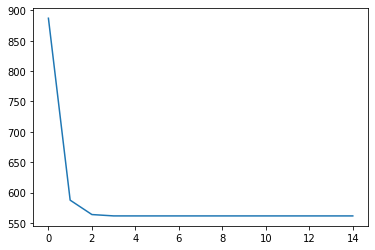

In [96]:
plt.plot(np.arange(len(costs1)),costs1)

In [97]:
pred1 = predict_estimates(X_test, w1)

In [98]:
accuracy(pred1, t_test, 0.5)

77.734375

In [99]:
roc_auc_score(t_test, pred1)

0.8097077260257175

In [100]:
w2, list_w2, list_var_w2, list_var_obj2, costs2, cols = fit_with_obj_feat_selection(X=X, T=T, iterations=15, 
                                                                            obj_threshold=0.2499, feat_threshold=10.0)

['0', '1', '2']
0
[ True  True  True]
['0', '1', '2']
[ 1.52302986 -0.23415337 -0.23413696]
(1038, 3)
0
[ 1.52302986 -0.23415337 -0.23413696]
[0.73662718 0.7148784  0.82801048 ... 0.88552981 0.83873518 0.83065368]
['0', '1', '2']
1
[ True  True  True]
['0', '1', '2']
[-1.11167907  1.72940176  0.80227082]
(1033, 3)
1
[-1.11167907  1.72940176  0.80227082]
[0.84328612 0.92323925 0.33166829 ... 0.11311457 0.35895942 0.10793253]
['0', '1', '2']
2
[ True  True  True]
['0', '1', '2']
[ 0.78990962  0.22382978 -0.07264019]
(1025, 3)
2
[ 0.78990962  0.22382978 -0.07264019]
[0.72875065 0.74872223 0.72901594 ... 0.77241359 0.75710611 0.63750164]
['0', '1', '2']
3
[ True  True  True]
['0', '1', '2']
[-0.02826075  0.95094036  0.39084484]
(1004, 3)
3
[-0.02826075  0.95094036  0.39084484]
[0.81181283 0.87033569 0.55959357 ... 0.4034211  0.58502319 0.35305076]
['0', '1', '2']
4
[ True  True  True]
['0', '1', '2']
[-0.0049288   1.06019083  0.35718247]
(997, 3)
4
[-0.0049288   1.06019083  0.35718247]
[0.

['0', '1', '2']
14
[ True  True  True]
['0', '1', '2']
[-0.00739581  1.07077951  0.34394705]
(993, 3)
14
[-0.00739581  1.07077951  0.34394705]
[0.82941745 0.88884507 0.59241527 0.65799749 0.89687983 0.26472993
 0.75749359 0.59404688 0.73753625 0.47978857 0.26286536 0.31342039
 0.22573479 0.26238915 0.852398   0.1734506  0.4010721  0.24765654
 0.56234676 0.58001901 0.38309965 0.58308684 0.10374738 0.70446884
 0.9407374  0.14214914 0.20825323 0.43652281 0.85090259 0.57861951
 0.80520058 0.39421351 0.64149739 0.88330042 0.24891294 0.07100826
 0.14825984 0.83620634 0.84069155 0.86125377 0.25426571 0.57167614
 0.87100371 0.40823627 0.19446399 0.83649073 0.19722677 0.12942816
 0.17082027 0.89335524 0.80801747 0.28233304 0.68835354 0.42793025
 0.74358293 0.68079466 0.89268742 0.84077891 0.39263872 0.30300765
 0.89184639 0.64766868 0.12723938 0.30513897 0.88144799 0.48765947
 0.138327   0.72471433 0.32953537 0.45635578 0.53002874 0.83368619
 0.77110688 0.30763273 0.14065039 0.17254146 0.547195

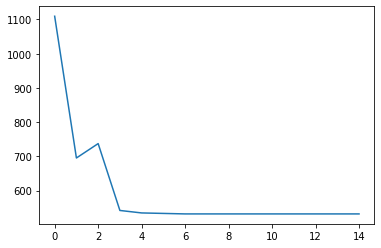

In [101]:
plt.plot(np.arange(len(costs2)),costs2)

In [102]:
def filter_columns(Xb_test, cols):
    Xb_test = pd.DataFrame(data=Xb_test, columns = [str(i) for i in range(Xb_test.shape[1])])
    filtered_Xb_test = np.array(Xb_test[cols])
    return filtered_Xb_test

In [103]:
def predict_estimates_with_sel(X_test, w, cols):
    Xb_test = preprocess(X_test)
    Xb_test = filter_columns(Xb_test=Xb_test, cols=cols)
    z_test = Xb_test.dot(w)
    probab_estimates = sigmoid(z_test)
    return probab_estimates

In [104]:
pred2 = predict_estimates_with_sel(X_test, w2, cols)

In [105]:
roc_auc_score(t_test, pred2)

0.8090946710193573

In [106]:
def var_of_obj(l, i):
    res = []
    for item in l:
        if len(item) > i:
            res.append(item[i])
    return res

In [107]:
# for i in range(len(list_var_obj2[0])):
#     plt.plot(var_of_obj(list_var_obj2, i))